Install most current PyMC3

In [1]:
!pip install -U git+https://github.com/pymc-devs/pymc3.git

  Cloning https://github.com/pymc-devs/pymc3.git to /tmp/pip-req-build-c3kn658j
    100% |████████████████████████████████| 2.8MB 11.3MB/s 
  Running setup.py bdist_wheel for pymc3 ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-w_6fz8qr/wheels/00/66/95/56ef7fc0279ccee186eb72eb3360f5978767d069c005eb64bd
  Running setup.py bdist_wheel for theano ... done
  Stored in directory: /home/fonnesbeck/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built pymc3 theano
  Found existing installation: Theano 1.0.3
    Uninstalling Theano-1.0.3:
      Successfully uninstalled Theano-1.0.3
  Found existing installation: pymc3 3.6
    Uninstalling pymc3-3.6:
      Successfully uninstalled pymc3-3.6


In [2]:
%reset -f
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os,sys,inspect
import pandas
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import scipy as sp
import theano.tensor as t

In [3]:
DATA_DIR = '../../Data/'

In [4]:
#read in dataset created in imputation notebook
data = pd.read_csv(DATA_DIR + "CleanedForRegression.csv")
#recode sex to female for indicator of being female in keepign with other variable coding
data['female'] = data['sex'] - 1
#drop data that is irrelevant or duplicated in other columms (ie just keep 1 indicator of age etc)
data = data.drop(['Unnamed: 0', 'incdate', 'agemth', 'incdate', 'incyear', 'incmonth', 'ageyrs', 'ageym', 'dimain' , 'dimainsp','sex'], axis = 1)


In [ ]:
import theano.tensor as tt
softmax = tt.nnet.softmax

In [ ]:
y = data['diag'].values

In [ ]:
#Imputation func from Fonnesbeck Enrollment Model.ipynb from infant_hearing_intervention
def fillna(x, value):
    x_masked = np.ma.masked_invalid(x)
    np.ma.set_fill_value(x_masked, value)
    return x_masked

In [ ]:
variable_cols = ['temp', 'glasgtot', 'female', 'rdtresult', 'vacmen', 'incphoto', 'incirrit', 
                'sbp', 'muac', 'incfont', 'incneck', 'incseiza', 'incseizh', 'age']

data[variable_cols].isnull().sum()

temp           0
glasgtot      53
female         0
rdtresult     10
vacmen        77
incphoto     204
incirrit      17
sbp           79
muac           6
incfont      205
incneck        7
incseiza       1
incseizh       3
age            0
dtype: int64

In [ ]:
data[variable_cols].head()

,temp,glasgtot,female,rdtresult,vacmen,incphoto,incirrit,sbp,muac,incfont,incneck,incseiza,incseizh,age
0,38.6,15.0,0,1.0,0.0,0.0,1.0,137.0,16.0,NaN,0.0,0.0,0.0,36.0
1,38.4,NaN,0,1.0,NaN,NaN,0.0,99.0,13.0,NaN,0.0,1.0,0.0,30.0
2,35.9,11.0,1,1.0,1.0,0.0,0.0,81.0,16.0,NaN,0.0,0.0,1.0,41.0
3,37.0,NaN,0,0.0,0.0,0.0,0.0,106.0,16.0,NaN,0.0,0.0,1.0,23.0
4,38.1,8.0,0,1.0,0.0,0.0,0.0,NaN,15.0,NaN,0.0,0.0,1.0,51.0


In [ ]:
(temp, glasgtot, female, rdtresult, 
 vacmen, incphoto, incirrit, 
 sbp, muac, incfont, incneck, 
 incseiza, incseizh, age) = data.fillna({'incseiza':0}).assign(glasgtot=data.glasgtot - 3,
                                                              sbp=data.sbp - data.sbp.mean(),
                                                              muac=data.muac - data.muac.mean(),
                                                              age=data.age - data.age.mean(),
                                                              temp=data.temp - data.temp.min())[variable_cols].values.T

In [ ]:
with pm.Model() as logistic_model:
    
    # Impute continuous variables
    if np.isnan(sbp).sum():
        mu_sbp = pm.Uniform("mu_sbp", lower = 50, upper = 200)
        var_sbp = pm.HalfNormal('var_sbp', sd = 1)
        x_sbp = pm.Normal('x_sbp', mu = mu_sbp, sd = var_sbp, observed=np.ma.masked_invalid(sbp))
    else:
        x_sbp = sbp
        
    if np.isnan(muac).sum(): 
        mu_muac = pm.Uniform("mu_muac", lower = 6, upper = 42)
        var_muac = pm.HalfCauchy('var_muac', beta = .5)
        x_muac = pm.Normal('x_muac', mu = mu_muac, sd = var_muac, observed=np.ma.masked_invalid(muac))
    else:
        x_muac = muac
    
    # Impute categorical variables
    if np.isnan(glasgtot).sum():
        p_glasgtot = pm.Dirichlet("p_glasgtot", np.ones(13))
        x_glasgtot = pm.Categorical('x_glasgtot', p_glasgtot, observed=np.ma.masked_invalid(glasgtot))
    else:
        x_glasgtot = glasgtot   
        
   
    # Impute binary variables
    if np.isnan(rdtresult).sum():
        p_rdtresult = pm.Beta("p_rdtresult", 1, 1)
        x_rdtresult = pm.Bernoulli('x_rdtresult', p_rdtresult, observed=np.ma.masked_invalid(rdtresult))
    else:
        x_rdtresult = rdtresult 
        
    if np.isnan(vacmen).sum():
        p_vacmen = pm.Beta("p_vacmen", 1, 1)
        x_vacmen = pm.Bernoulli('x_vacmen', p_vacmen, observed=np.ma.masked_invalid(vacmen))
    else:
        x_vacmen = vacmen          
        
    if np.isnan(incphoto).sum():
        p_incphoto = pm.Beta("p_incphoto", 1, 1)
        x_incphoto = pm.Bernoulli('x_incphoto', p_incphoto, observed=np.ma.masked_invalid(incphoto))
    else:
        x_incphoto = incphoto
        
    if np.isnan(incirrit).sum():
        p_incirrit = pm.Beta("p_incirrit", 1, 1)
        x_incirrit = pm.Bernoulli('x_incirrit', p_incirrit, observed=np.ma.masked_invalid(incirrit))
    else:
        x_incirrit = incirrit
        
    if np.isnan(incfont).sum():
        p_incfont = pm.Beta("p_incfont", 1, 1)
        x_incfont = pm.Bernoulli('x_incfont', p_incfont, observed=np.ma.masked_invalid(incfont))
    else:
        x_incfont = incfont       
        
    if np.isnan(incneck).sum():
        p_incneck = pm.Beta("p_incneck", 1, 1)
        x_incneck = pm.Bernoulli('x_incneck', p_incneck, observed=np.ma.masked_invalid(incneck))
    else:
        x_incneck = incneck
        
    if np.isnan(incseizh).sum():
        p_incseizh = pm.Beta("p_incseizh", 1, 1)
        x_incseizh = pm.Bernoulli('x_incseizh', p_incseizh, observed=np.ma.masked_invalid(incseizh))
    else:
        x_incseizh = incseizh          
        
    X = [x_rdtresult, x_glasgtot, x_vacmen, female, x_incphoto, x_incirrit, temp, age,
        x_sbp, x_muac, x_incfont, x_incneck, x_incseizh, incseiza]

    N, K = len(X), len(set(y))
    
    μ = pm.Normal('μ', 0, sd=5, shape=K)
    effects = pm.Normal('effects', mu=0, sd=5, shape=(N, K))
    
    # expected parameter
    p = softmax(μ + tt.stack(X, axis=1).dot(effects))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Categorical('Y_obs', p=p, observed=y)

/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/pymc3/model.py:1277: UserWarning: Data in x_sbp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/pymc3/model.py:1277: UserWarning: Data in x_muac contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/pymc3/model.py:1277: UserWarning: Data in x_glasgtot contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/pymc3/model.py:1277: UserWarning: Data in x_rdtresult contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


In [ ]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, cores=2)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [effects, μ, p_incseizh, p_incneck, p_incfont, p_incirrit, p_incphoto, p_vacmen, p_rdtresult, p_glasgtot, x_muac_missing, var_muac, mu_muac, x_sbp_missing, var_sbp, mu_sbp]
>CategoricalGibbsMetropolis: [x_glasgtot_missing]
>BinaryGibbsMetropolis: [x_rdtresult_missing, x_vacmen_missing, x_incphoto_missing, x_incirrit_missing, x_incfont_missing, x_incneck_missing, x_incseizh_missing]
Sampling 2 chains:  11%|█▏        | 687/6000 [06:10<1:12:11,  1.23draws/s]

In [23]:
_varnames = [varname.name for varname in logistic_model.free_RVs if (varname.name.startswith('mu_')
                                                                     or varname.name.startswith('p_'))]

GridSpec(1, 2, width_ratios=[3, 1])

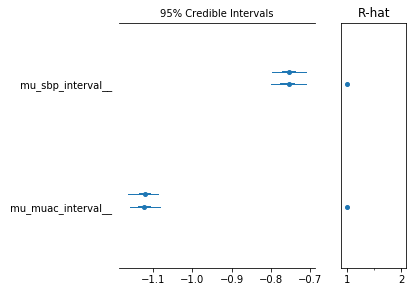

In [24]:
pm.forestplot(trace, varnames=_varnames)

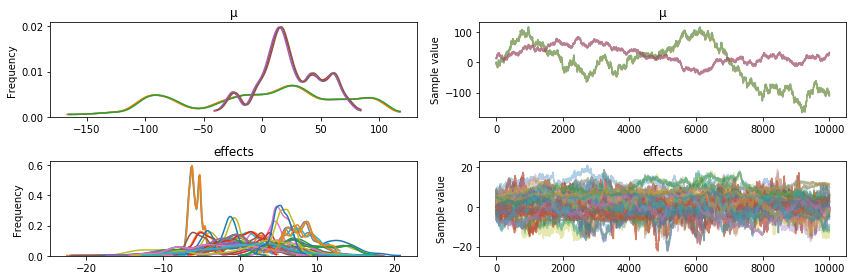

In [176]:
pm.forestplot(trace, varnames = ["μ", "effects"]);


In [166]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
x_rdtresult_missing__0,0.175500,0.380394,0.005916,0.000000,1.000000,3764.310487,1.000918
x_rdtresult_missing__1,0.170000,0.375633,0.006215,0.000000,1.000000,3925.090631,1.001565
x_rdtresult_missing__2,0.267000,0.442392,0.005999,0.000000,1.000000,4945.550340,0.999905
x_rdtresult_missing__3,0.276750,0.447392,0.006177,0.000000,1.000000,4525.342418,1.000382
x_rdtresult_missing__4,0.190250,0.392498,0.006547,0.000000,1.000000,3757.930293,1.000046
x_rdtresult_missing__5,0.174750,0.379753,0.006329,0.000000,1.000000,3758.640458,0.999754
x_rdtresult_missing__6,0.165250,0.371406,0.005195,0.000000,1.000000,3535.677703,0.999990
x_rdtresult_missing__7,0.169500,0.375193,0.005495,0.000000,1.000000,3889.331530,0.999928
x_rdtresult_missing__8,0.185000,0.388298,0.005927,0.000000,1.000000,3561.387560,0.999752
x_rdtresult_missing__9,0.229250,0.420350,0.005512,0.000000,1.000000,4502.956811,0.999779


In [177]:
import pickle 
with open('trace10k10k13.pkl', 'wb') as buff:
    pickle.dump(trace, buff)

In [27]:
import pickle
#this loads a saved trace file
with open('trace10k10ktd13.pkl', 'rb') as buff:
    external_trace = pickle.load(buff)

In [6]:
#pm.energyplot(trace)

In [141]:
#pm.traceplot(trace);

In [142]:
#pm.forestplot(trace, varnames=['effects'])

In [3]:
#pm.plots.densityplot(trace)

In [140]:
#pm.plots.plot_posterior(trace);

# Posterior predictive check
How does the model perform in predicting the outcomes of the subjects that went into the data?

In [167]:
ppc = pm.sample_ppc(trace, samples=500, model=logistic_model)

100%|██████████| 500/500 [00:17<00:00, 27.94it/s]


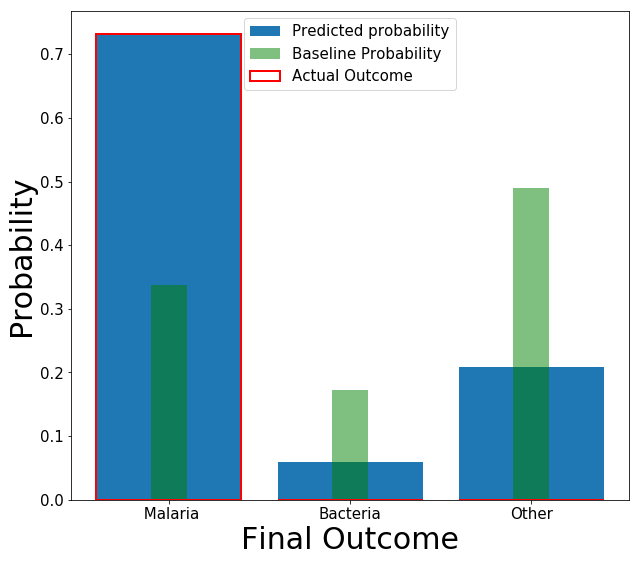

In [168]:
#ppc for person 0, example of a true malaria case
ind = 0
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

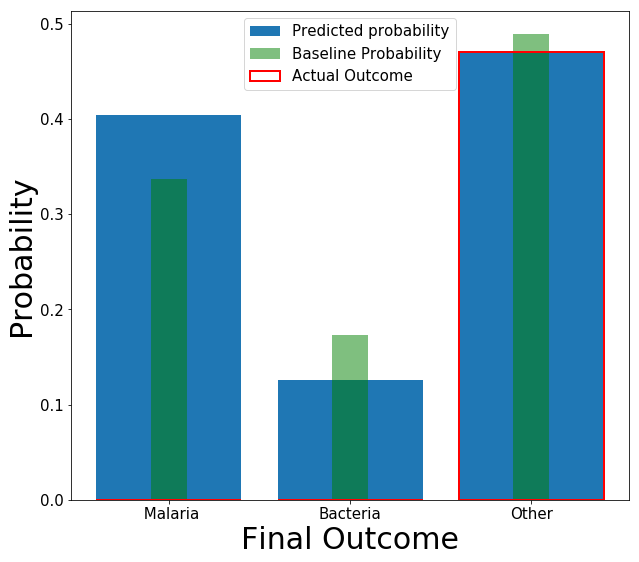

In [124]:
#ppc for person 1, example of a true neither case, note that positive rdttest makes this one miss badly
ind = 1
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

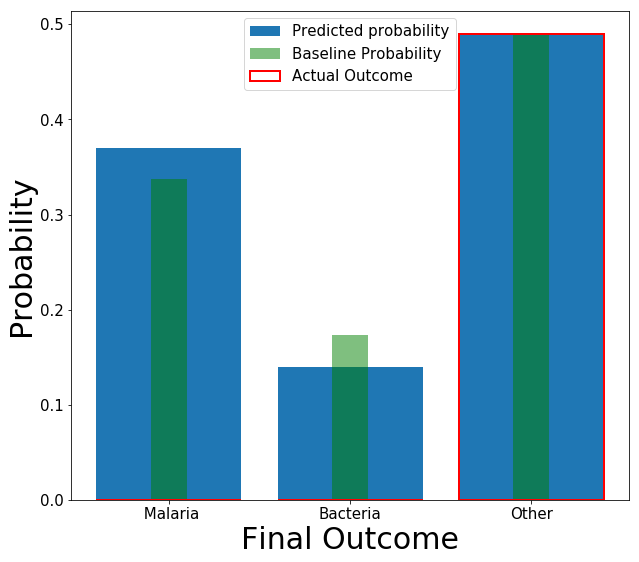

In [125]:
#ppc for person 3, negative rdt test makes this one very certain (accuratley this time)
ind = 3
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

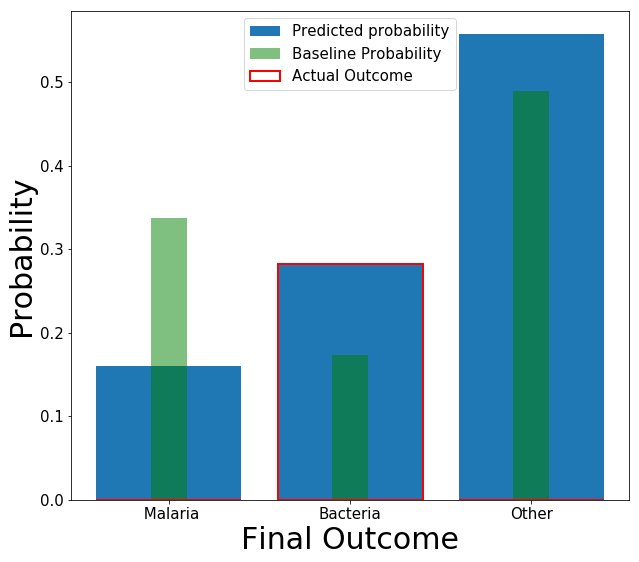

In [126]:
#ppc for person 10, example of a true bacteria
ind = 10
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind,0] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind,0] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

In [127]:
result = pd.DataFrame({'diag':y})
result['rdtresult'] = rdtresult
result['p_mal'] = np.sum(ppc['Y_obs'][:,:,0] == 0, axis = 0) / 500
result['p_bact'] = np.sum(ppc['Y_obs'][:,:,0] == 1, axis = 0) / 500
result['p_other'] = np.sum(ppc['Y_obs'][:,:,0] == 2, axis = 0) / 500
#result['p_max'] = np.amax(result.drop(['diag'], axis=1), axis = 1)
#result['prediction'] = 0
#result['prediction'][np.where(result['p_max'] == result['p_bact'], 'yes', 'no') == 'yes'] = 1
#result['prediction'][np.where(result['p_max'] == result['p_other'], 'yes', 'no') == 'yes'] = 2

# Brier Score
This is a measure of model certainty and accuracy  
https://en.wikipedia.org/wiki/Brier_score

In [128]:
p_mal = result['p_mal']
p_bact = result['p_bact']
p_other = result['p_other']
d_mal = (result['diag'] == 0).astype(int)
d_bact = (result['diag'] == 1).astype(int)
d_other = (result['diag'] == 2).astype(int)
BS = (sum(np.square(p_mal - d_mal)) + sum(np.square(p_bact - d_bact)) + sum(np.square(p_other - d_other))) / len(y)
BS
sum(y == 2) / 500

0.47

# More intuitive: Given someone is a true positive, how does it affect their prediction for that outcome?
We start by knowing the baseline prediction, which comes from prevavlence in a sample (if we know nothing about a person we assume their probability based solely from population averages.)

%malaria: .324  
%bacteria: .166  
%other: .470

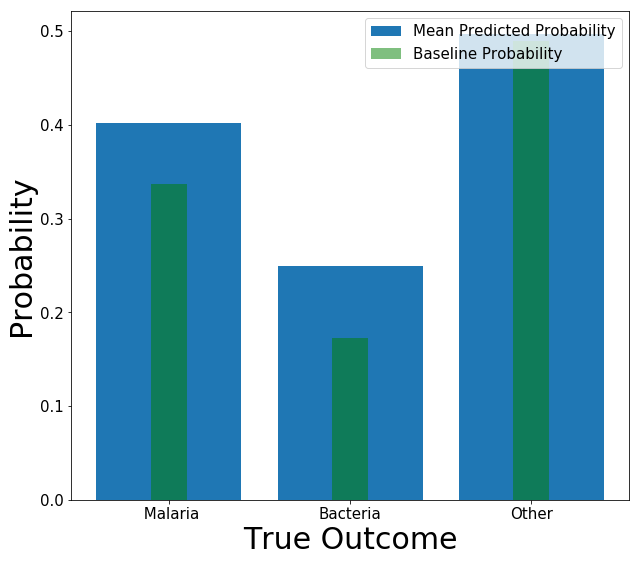

In [129]:
#Average predicted prob of outcome given outcome
avg_mal_prob = sum(p_mal * d_mal) / sum(d_mal)
avg_bact_prob = sum(p_bact * d_bact) / sum(d_bact)
avg_other_prob = sum(p_other * d_other) / sum(d_other)

#plot
plt.bar([" Malaria","Bacteria","Other"], height=[
    avg_mal_prob,
    avg_bact_prob,
    avg_other_prob], width=0.8, label = "Mean Predicted Probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')



plt.legend(loc = 1 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("True Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

This plot suggests improved prediction by the regression.  Because the model was built in a primarily non-data-driven way and exploits linear relationships between predictor and outcome it is unlikely that this is due to overfitting.  If a bootstrapped sample has similarly good predictive power it should provide evidence of internal validation and confidence that overfitting is not a problem.

# Resimulating outcomes based on MLEs of coefficients
This should be very similar to the PPC but is generalizeable to new data so if someone new were in need of prediction this is the process that would generate their predicted outcomes.

In [177]:
coef = pm.summary(trace, varnames = ["effects"])

In [179]:
#Make a Matrix the rows of which are beta1, ...., betak and the columns represent mal, bact, and other.

coef_mal = coef.iloc[::3, 0]
coef_bact = coef.iloc[1::3, 0]
coef_other = coef.iloc[2::3, 0]

In [180]:
coef_matrix = pd.DataFrame({"coef_mal":coef_mal})
coef_matrix["coef_bact"] = coef_bact.values
coef_matrix["coef_other"] = coef_other.values
mu_vect = pm.summary(trace, varnames = ["μ"])["mean"].values

In [260]:
with pm.Model() as posterior_sim:
    
    # Impute continuous variables
    if np.isnan(sbp).sum():
        mu_sbp = pm.Uniform("mu_sbp", lower = 50, upper = 200)
        var_sbp = pm.HalfNormal('var_sbp', sd = 1)
        x_sbp = pm.Normal('x_sbp', mu = mu_sbp, sd = var_sbp, observed=np.ma.masked_values(fillna(sbp, 999), value=999))
    else:
        x_sbp = sbp
        
#    if np.isnan(temp).sum(): #Temp happens to have no missing so this code runs the else: chunk
#        mu_temp = pm.Uniform("mu_temp", lower = 34, upper = 42)
#        var_temp = pm.HalfCauchy('var_temp', beta = .5)
#        x_temp = pm.Normal('x_temp', mu = mu_temp, sd = var_temp, observed=np.ma.masked_values(temp, value = np.nan))
#    else:
#        x_temp = temp

    if np.isnan(age).sum():
        mu_age = pm.Uniform("mu_age", lower = 1, upper = 144)
        var_age = pm.HalfCauchy('var_age', beta = .5)
        x_age = pm.Normal('x_age', mu = mu_age, sd = var_age, observed=np.ma.masked_values(age, value = np.nan))
    else:
        x_age = age
        
    if np.isnan(muac).sum(): 
        mu_muac = pm.Uniform("mu_muac", lower = 6, upper = 42)
        var_muac = pm.HalfCauchy('var_muac', beta = .5)
        x_muac = pm.Normal('x_muac', mu = mu_muac, sd = var_muac, observed=np.ma.masked_values(fillna(muac, 999), value=999))
    else:
        x_muac = muac
        
    
    # Impute categorical variables
    if np.isnan(glasgtot).sum():
        p_glasgtot = pm.Dirichlet("p_glasgtot", np.ones(13))
        x_glasgtot = pm.Categorical('x_glasgtot', p_glasgtot, observed=np.ma.masked_invalid(glasgtot))
    else:
        x_glasgtot = glasgtot   
        
   
    # Impute binary variables
    if np.isnan(rdtresult).sum():
        p_rdtresult = pm.Beta("p_rdtresult", 1, 1)
        x_rdtresult = pm.Bernoulli('x_rdtresult', p_rdtresult, observed=np.ma.masked_values(fillna(rdtresult, 999), value=999))
    else:
        x_rdtresult = rdtresult 
        
    if np.isnan(vacmen).sum():
        p_vacmen = pm.Beta("p_vacmen", 1, 1)
        x_vacmen = pm.Bernoulli('x_vacmen', p_vacmen, observed=np.ma.masked_values(fillna(vacmen, 999), value=999))
    else:
        x_vacmen = vacmen         
        
    if np.isnan(female).sum():
        p_female = pm.Beta("p_female", 1, 1)
        x_female = pm.Bernoulli('x_female', p_female, observed=np.ma.masked_values(fillna(female, 999), value=999))
    else:
        x_female = female     
        
    if np.isnan(incphoto).sum():
        p_incphoto = pm.Beta("p_incphoto", 1, 1)
        x_incphoto = pm.Bernoulli('x_incphoto', p_incphoto, observed=np.ma.masked_values(fillna(incphoto, 999), value=999))
    else:
        x_incphoto = incphoto
        
    if np.isnan(incirrit).sum():
        p_incirrit = pm.Beta("p_incirrit", 1, 1)
        x_incirrit = pm.Bernoulli('x_incirrit', p_incirrit, observed=np.ma.masked_values(fillna(incirrit, 999), value=999))
    else:
        x_incirrit = incirrit
        
    if np.isnan(incfont).sum():
        p_incfont = pm.Beta("p_incfont", 1, 1)
        x_incfont = pm.Bernoulli('x_incfont', p_incfont, observed=np.ma.masked_values(fillna(incfont, 999), value=999))
    else:
        x_incfont = incfont       
        
    if np.isnan(incneck).sum():
        p_incneck = pm.Beta("p_incneck", 1, 1)
        x_incneck = pm.Bernoulli('x_incneck', p_incneck, observed=np.ma.masked_values(fillna(incneck, 999), value=999))
    else:
        x_incneck = incneck
        
    #Because there is only 1 missing value in this one the imputation won't behave so I'll just impute the one value to 0    
    incseiza[np.isnan(incseiza)] = 0
    x_incseiza = incseiza 
        
    if np.isnan(incseizh).sum():
        p_incseizh = pm.Beta("p_incseizh", 1, 1)
        x_incseizh = pm.Bernoulli('x_incseizh', p_incseizh, observed=np.ma.masked_values(fillna(incseizh, 999), value=999))
    else:
        x_incseizh = incseizh          
        
    X = [x_rdtresult,x_glasgtot,x_vacmen,x_age,x_female,x_incphoto,x_incirrit,
        x_sbp,x_muac,x_incfont,x_incneck,x_incseizh,x_incseiza]        
    
    #test
#    X = [rdtresult,glasgtot,vacmen,age,female,incphoto,incirrit,
#        sbp,muac,incfont,incneck,incseizh,incseiza]
    
    μ = mu_vect
    effects = coef_matrix.values
    
    # expected parameter
    p = softmax(μ + tt.stack(X, axis = 1).dot(effects))
    
    # Likelihood (sampling distribution) of observations
    Y_post = pm.Categorical('Y_post', p=p)

In [264]:
with posterior_sim:
    sim_trace = pm.sample(100, tune=100, njobs=2, nuts_kwargs={'target_accept':0.99,'max_treedepth':12})

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p_incseizh, p_incneck, p_incfont, p_incirrit, p_incphoto, p_vacmen, p_rdtresult, p_glasgtot, x_muac_missing, var_muac, mu_muac, x_sbp_missing, var_sbp, mu_sbp]
>CategoricalGibbsMetropolis: [Y_post, x_glasgtot_missing]
>BinaryGibbsMetropolis: [x_rdtresult_missing, x_vacmen_missing, x_incphoto_missing, x_incirrit_missing, x_incfont_missing, x_incneck_missing, x_incseizh_missing]
Sampling 2 chains:   0%|          | 0/400 [00:00<?, ?draws/s]


RuntimeError: Chain 1 failed.

In [ ]:
#Baseline prediction

#plt.bar([" Malaria","Bacteria","Other"], height=[
#    sum(y == 0) / 500,
#    sum(y == 1) / 500,
#    sum(y == 2) / 500], width=0.8)

#plt.ylabel("Probability", fontsize = 30)
#plt.xlabel("Final Diagnosis", fontsize = 30)
#plt.rcParams["figure.figsize"] = (10, 9)
#plt.tick_params(axis='both', which='major', labelsize=15)
#plt.tick_params(axis='both', which='minor', labelsize=8)